In [21]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib as plt
import requests
from urllib.parse import quote
import json
import pyproj
import os
os.chdir("D:/Projects/crime-prediction")

import common.census_tract as tract

pyproj.datadir.set_data_dir("D:/ProgramData/anaconda3/envs/crime-prediction/Library/share/proj")

In [22]:
household_income_path = 'data/household_income.csv'
census_tracts_path='data/preprocessed/census_tracts_data.geojson'

In [23]:
def parse_census_tracts_data():
    gdf = gpd.read_file(census_tracts_path)
    return gdf

In [24]:
tracts_gdf = parse_census_tracts_data()

In [25]:
def parse_household_income():
    # Read household income data from CSV file, selecting only needed columns
    df = pd.read_json(household_income_path)
    df.columns = df.iloc[0] # Set column names from the first row
    df = df[1:].reset_index(drop=True) # Remove the header row from the data
    
    # Rename columns to more concise names
    df = df.rename(columns={'NAME': 'Tract Name', 'S1903_C03_001E': 'HouseHold Income'})

    # Convert column 'HouseHold Income' to integer
    df['HouseHold Income'] = pd.to_numeric(df['HouseHold Income'])
    
    # Format tract names using helper function
    df["Tract Name"] = df.apply(lambda row: tract.formatTractName(row["Tract Name"]) , axis=1)
    
    # Create tract group names using helper function
    df["Tract Group Name"] = df.apply(lambda row: tract.formatTractGroupName(row["Tract Name"]) , axis=1)

    # Aggregate data at the tract level (mean values)
    df_1 = df.groupby("Tract Name")[["HouseHold Income"]].agg('mean').reset_index()
    
    # Aggregate data at the tract group level (mean values)
    df_2 = df.groupby("Tract Group Name")[["HouseHold Income"]].agg('mean') \
                        .reset_index() \
                        .rename(columns={'Tract Group Name': 'Tract Name'})
    
    # Combine both aggregations and calculate mean values if there are duplicates
    df = pd.concat([df_1, df_2]).groupby("Tract Name")[["HouseHold Income"]].agg('mean').reset_index()
    
    # Filter to only include tracts that exist in the tracts_gdf dataset
    df = df[df['Tract Name'].isin(set(tracts_gdf["Tract Name"]))]
    
    # Merge with geographic data from tracts_gdf
    df = pd.merge(df, tracts_gdf, on='Tract Name', how='inner')
    
    # Convert to GeoDataFrame with appropriate coordinate reference system
    df = gpd.GeoDataFrame(df, geometry=df["geometry"], crs="EPSG:4326")
    
    return df

In [26]:
household_income_gdf = parse_household_income()

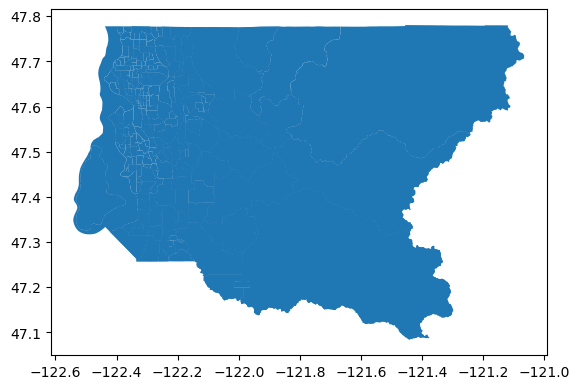

In [27]:
household_income_gdf.plot()
household_income_gdf.to_file('data/preprocessed/household_income_data.geojson', driver="GeoJSON")